# Szanowni Państwo, jak co tydzień nowy notatnik. 
__Bardzo dziękuję Maciejowi Stanuchowi za pomoć w przygotowaniu tego notatnika.__

Na początek biblioteki:

In [20]:
import numpy as np
import matplotlib.pylab as plt
from skimage import color, morphology
from scipy import signal
import scipy
%matplotlib inline

Wczytanie obrazu oraz konwersja na skalę szarości (8bit)

In [21]:
im = plt.imread('Xray-300x247.jpg')
im.shape
im_gray = color.rgb2gray(im)

Dla ułatwienia tworzymy funkcję, która pomoże nam porównywać obrazy, które wytworzymy:

In [22]:
def compareImages(img1, img2):
    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(img1, cmap='gray')
    plt.title('original')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img2, cmap='gray')
    plt.title('processed')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    if (img1.dtype == bool and img2.dtype == bool):
        plt.imshow(np.asarray(img2, dtype=np.uint16) - np.asarray(img1, dtype=np.uint16), cmap='gray')
    else:
        plt.imshow(img2 - img1, cmap='gray')
    plt.title('difference')
    plt.axis('off')

Tworzymy funkcję do SE

In [23]:
def isInCircle(x, y, center_x, center_y, radius):
    out = (x - center_x)**2 + (y - center_y)**2 < radius**2
    return out

def createDisk(radius, SE):
    disk = np.zeros_like(SE)
    x_SE, y_SE = np.shape(SE)
    x_center = int(np.floor(x_SE / 2))
    y_center = int(np.floor(y_SE / 2))
    for i in range(0,np.shape(SE)[0]):
        for j in range(0, np.shape(SE)[1]):
            disk[i,j] = isInCircle(i, j, x_center, y_center, radius + 0.2)
    return disk

def createSE(size = (3,3), shape='filled', radius = -1):
    SE = np.ones(size, np.uint8)
    if shape == 'filled':
        return SE
    elif shape == 'disk':
        if radius == -1:
            radius = int(np.floor(np.max(np.shape(SE)) / 2))
        return createDisk(radius, SE)

# __Dopasowanie histogramu__
Dopasowanie histogramu na podstawie Cumulative Distribution Function (http://paulbourke.net/miscellaneous/equalisation/). Dopasowujemy histogram obrazu do rozkładu histogramu wzorca.

In [24]:
from skimage.exposure import cumulative_distribution
#import matplotlib.pylab as plt
import numpy as np

def cdf(im):
    '''
    computes the CDF of an image im as 2D numpy ndarray
    '''
    c, b = cumulative_distribution(im) 
    # pad the beginning and ending pixels and their CDF values
    c = np.insert(c, 0, [0]*b[0])
    c = np.append(c, [1]*(255-b[-1]))
    return c

def hist_matching(c, c_t, im):
    '''
    c: CDF of input image computed with the function cdf()
    c_t: CDF of template image computed with the function cdf()
    im: input image as 2D numpy ndarray
    returns the modified pixel values
    ''' 
    pixels = np.arange(256)
    # find closest pixel-matches corresponding to the CDF of the input image, given the value of the CDF H of   
    # the template image at the corresponding pixels, s.t. c_t = H(pixels) <=> pixels = H-1(c_t)
    new_pixels = np.interp(c, c_t, pixels) 
    im = (np.reshape(new_pixels[im.ravel()], im.shape)).astype(np.uint8)
    return im

Ładujemy drugi obraz o innym histogramie

In [25]:
im_2 = plt.imread('CT_lungs.png')
im_2.shape
im_gray_2 = color.rgb2gray(im_2)

konwersja dla ułatwienia kolejnych działań

In [26]:
im_gray_u8 = np.asarray(im_gray*255, dtype=np.uint8)
im_gray_2_u8 = np.asarray(im_gray_2*255, dtype=np.uint8)

In [27]:
def compareHistograms(img1, img2, bins = 128, cumulative = False):
    plt.figure()
    plt.hist(img1.ravel(), bins = bins, cumulative = cumulative)
    plt.title('Image 1')
    plt.show()
    plt.figure()
    plt.hist(img2.ravel(), bins = bins, cumulative = cumulative)
    plt.title('Image 2')
    plt.show()

wywołanie funkcji (cdf obrazu, cdf wzorca, obraz dopasowywany) Ustalcie co jest obrazem źródłowym, a co docelowym) tutaj zastosowano inne nazewnictwo, z którym możecie się spotkać w literaturze.

In [28]:
res = hist_matching(cdf(im_gray_u8), cdf(im_gray_2_u8), im_gray_u8)

wizualizacja rezultatów

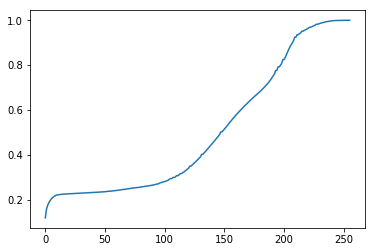

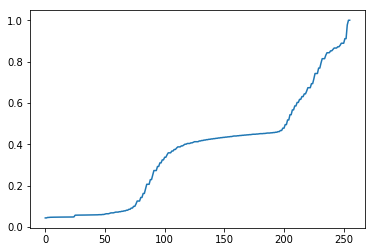

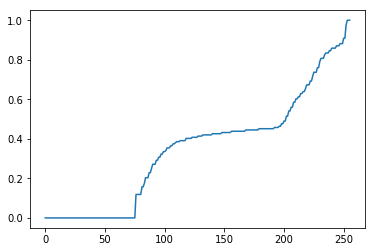

In [29]:
plt.plot(cdf(im_gray_u8))
plt.show()
plt.plot(cdf(im_gray_2_u8))
plt.show()
plt.plot(cdf(res))
plt.show()

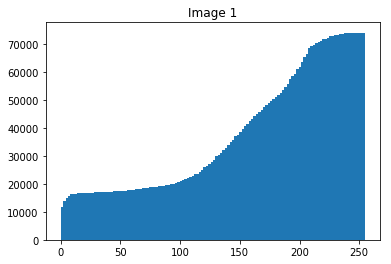

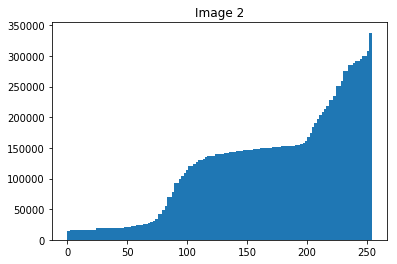

In [30]:
compareHistograms(im_gray_u8, im_gray_2_u8, cumulative = True)

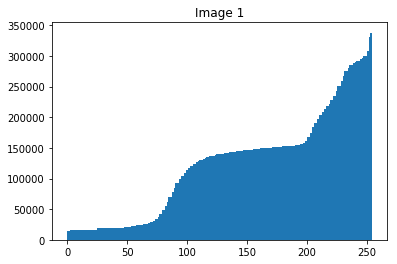

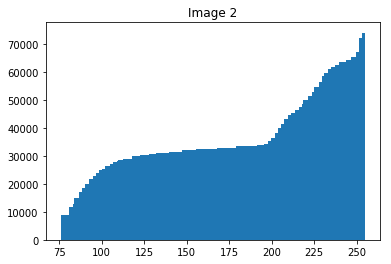

In [31]:
compareHistograms(im_gray_2_u8, res, bins=256, cumulative = True)

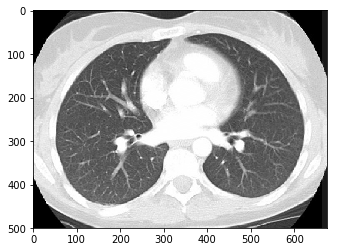

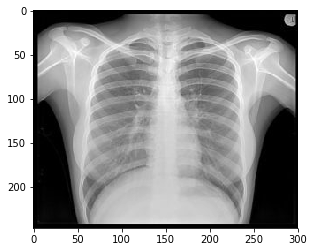

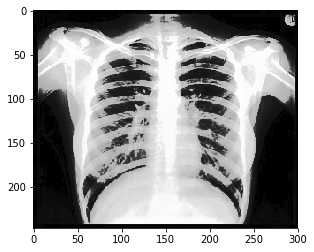

In [32]:
plt.imshow(im_gray_2_u8, cmap='gray')
plt.show()
plt.imshow(im_gray_u8, cmap='gray')
plt.show()
plt.imshow(res, cmap='gray')
plt.show()

# __FFT obrazu__

In [33]:
im_fft = np.fft.fft2(im_gray)

In [34]:
def showFFT(fft):
    plt.imshow(np.log10(abs(fft)), cmap='gray')
    plt.axis('off')
    plt.show()
def showImage(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

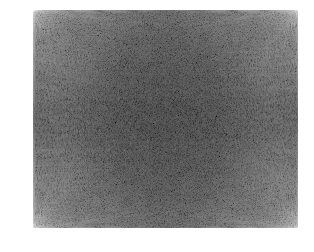

In [35]:
showFFT(im_fft)

filtracja filtrem dolnoprzepustowym (sprawdźcie jaki wpływ ma rozmiar maski)

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8)

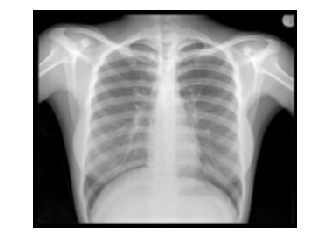

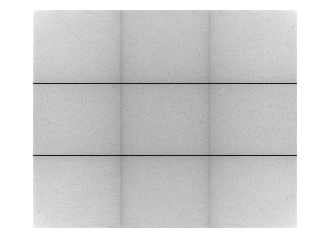

In [36]:
mask = createSE((3,3))
display(mask)
im_filtered = signal.convolve2d(im_gray, mask)
im_filtered_fft = np.fft.fft2(im_filtered)
showImage(im_filtered)
showFFT(im_filtered_fft)